In [1]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import os
from keras import backend

In [2]:
!unzip /content/drive/MyDrive/Animals-10.zip -d /content/Animals-10

Streaming output truncated to the last 5000 lines.
  inflating: /content/Animals-10/Animals-10/spider/spider (2373).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2374).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2375).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2376).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2377).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2378).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2379).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (238).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (238).jpg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2380).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2381).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2382).jpeg  
  inflating: /content/Animals-10/Animals-10/spider/spider (2383).jpeg  
  inflating: /co

In [3]:
#Filter out corrupted or unsupported images for the dataset
num_skipped = 0
for folder_name in ("butterfly", "cat", "chicken", "cow", "dog", "elephant", "horse", "sheep", "spider", "squirrel"):
    folder_path = os.path.join("/content/Animals-10/Animals-10", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 60 images


In [4]:
image_size = (320, 320)
batch_size = 32

In [5]:
#Splitting dataset into 80% Training, 20% Validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Animals-10/Animals-10",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Animals-10/Animals-10",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 26119 files belonging to 10 classes.
Using 20896 files for training.
Found 26119 files belonging to 10 classes.
Using 5223 files for validation.


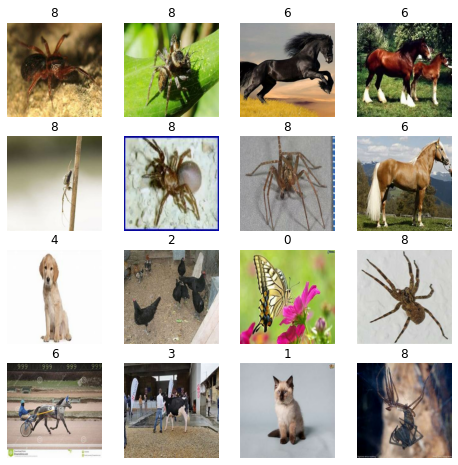

In [6]:
#Visualization of data - First 16 images
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
#Using data_augmentation to rotate the images by up to 10 degrees for increased randomness
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1)])

In [8]:
img_width = 320
img_height = 320

if backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    modelx = data_augmentation(inputs)
    modelx = layers.Rescaling(1.0 / 255)(modelx)
    modelx = layers.Conv2D(32, 3, strides=2, padding="same", activation = 'relu')(modelx)
    modelx = layers.Conv2D(64, 3, padding="same", activation='relu')(modelx)
    previous_block_activation = modelx  # Set aside residual
    
    for size in [128, 256, 512, 384]:
        modelx = layers.Activation("relu")(modelx)
        modelx = layers.SeparableConv2D(size, 3, padding="same")(modelx)
        modelx = layers.BatchNormalization()(modelx)

        modelx = layers.Activation("relu")(modelx)
        modelx = layers.SeparableConv2D(size, 3, padding="same")(modelx)
        modelx = layers.BatchNormalization()(modelx)

        modelx = layers.MaxPooling2D(3, strides=2, padding="same")(modelx)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation) # Project residual
        modelx = layers.add([modelx, residual])  # Add back residual
        previous_block_activation = modelx  # Set aside next residual
    
    modelx = layers.SeparableConv2D(1024, 3, padding="same", activation = 'relu')(modelx)
    modelx = layers.GlobalAveragePooling2D()(modelx)
    
    outputs = layers.Dense(num_classes, activation="softmax")(modelx)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape, num_classes=10)

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]

#Compile the model with Optimizer set as Adam, Loss Function of Sparse Categorical Cross Entropy, and additional metric set as Accuracy.
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 320, 320, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['rescaling[0][0]']          

In [ ]:
model.fit(train_ds, epochs=15, callbacks=callbacks, validation_data=val_ds)

Epoch 1/15
653/653 [==============================] - 979s 1s/step - loss: 1.6948 - accuracy: 0.4040 - val_loss: 2.7802 - val_accuracy: 0.2144
Epoch 2/15
653/653 [==============================] - 964s 1s/step - loss: 1.1905 - accuracy: 0.5913 - val_loss: 1.7248 - val_accuracy: 0.3668
Epoch 3/15
653/653 [==============================] - 964s 1s/step - loss: 0.9404 - accuracy: 0.6813 - val_loss: 1.5296 - val_accuracy: 0.4453
Epoch 4/15
653/653 [==============================] - 964s 1s/step - loss: 0.8040 - accuracy: 0.7275 - val_loss: 3.0477 - val_accuracy: 0.2736
Epoch 5/15
653/653 [==============================] - 963s 1s/step - loss: 0.7034 - accuracy: 0.7631 - val_loss: 2.8111 - val_accuracy: 0.4003
Epoch 6/15
653/653 [==============================] - 962s 1s/step - loss: 0.6287 - accuracy: 0.7891 - val_loss: 1.0124 - val_accuracy: 0.6783
Epoch 7/15
653/653 [==============================] - 962s 1s/step - loss: 0.5659 - accuracy: 0.8139 - val_loss: 1.3053 - val_accuracy: 0.5807

In [ ]:
#extra epoch to increase validation accuracy
model.fit(train_ds, epochs=4, callbacks=callbacks, validation_data=val_ds)

Epoch 1/4
653/653 [==============================] - 948s 1s/step - loss: 0.3078 - accuracy: 0.8984 - val_loss: 0.5739 - val_accuracy: 0.8262
Epoch 2/4
653/653 [==============================] - 951s 1s/step - loss: 0.2865 - accuracy: 0.9056 - val_loss: 0.7903 - val_accuracy: 0.7691
Epoch 3/4
653/653 [==============================] - 951s 1s/step - loss: 0.2745 - accuracy: 0.9096 - val_loss: 0.5956 - val_accuracy: 0.8260
Epoch 4/4
653/653 [==============================] - 951s 1s/step - loss: 0.2541 - accuracy: 0.9155 - val_loss: 0.5997 - val_accuracy: 0.8116


In [ ]:
model.save("imagereg_org")
model.save("/content/drive/MyDrive/imagereg_org")

INFO:tensorflow:Assets written to: imagereg_org/assets


INFO:tensorflow:Assets written to: imagereg_org/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/imagereg_org/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/imagereg_org/assets


In [ ]:
#Convert model to TF Lite format (without quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#Convert the model
model_tflite = converter.convert()

#Save the model to disk
open("imagereg.tflite", "wb").write(model_tflite)
open("/content/drive/MyDrive/imagereg.tflite", "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpsq8lo90a/assets


INFO:tensorflow:Assets written to: /tmp/tmpsq8lo90a/assets


6741560

In [ ]:
#Testing of the model

import numpy as np

image = keras.preprocessing.image.load_img("/content/Animals-10/Animals-10/dog/dog (100).jpeg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
pred = np.squeeze(predictions)

print(pred)
classes = {0: "butterfly", 1: "cat", 2: "chicken", 3: "cow", 4: "dog", 5: "elephant", 6: "horse", 7: "sheep", 8: "spider", 9: "squirrel"}
highest_pred_loc = np.argmax(pred)
accuracy = pred[highest_pred_loc]
animal = classes[highest_pred_loc]
print("This image is %.2f percent %s." % (100 * accuracy, animal))

[8.4916261e-09 1.6804132e-07 8.4849361e-10 2.5467446e-11 9.9999940e-01
 9.1982411e-12 8.2732793e-11 1.5887301e-07 4.0647254e-07 8.5015932e-09]
This image is 100.00 percent dog.
